# Train Acquisiton Function Selector
ELA features of initial design -> performance regression -> argmin/max -> schedule
## (Function) Definitions

In [3]:
from pathlib import Path
from train_ela import *


def check_existance(dict_of_values, df):
    v = df.iloc[:, 0] == df.iloc[:, 0]
    for key, value in dict_of_values.items():
        v &= df[key] == value
    return v.any()


def filter_by_testset(df, index_df):
    group_keys = ["bbob_dimension", "bbob_function", "bbob_instance", "seed"]
    groups = df.groupby(by=group_keys)
    new_df = []
    for gid, gdf in groups:
        dict_of_values = {k: v for k, v in zip(group_keys, gid)}
        exists = check_existance(dict_of_values, index_df)
        if exists:
            new_df.append(gdf)
    df = pd.concat(new_df)
    return df


fn_testP = "tmp/meta_learning_bbob/testP.csv"

fn_initial_design_raw = Path("tmp/meta_learning_bbob/initial_design_raw.csv")
fn_initial_design = Path("tmp/meta_learning_bbob/initial_design.csv")
fn_rollout_data = Path("tmp/meta_learning_bbob/rollout_data.csv")
fn_ela_features = Path("tmp/meta_learning_bbob/ela_features.csv")
fn_rank_df = Path("tmp/meta_learning_bbob/ranks.csv")
fn_convergence_df_afsvbs = Path("tmp/meta_learning_bbob/rollout_test_afsvbs.csv")
fn_hydra_config = ".hydra/config.yaml"
figoutdir = "tmp/meta_learning_bbob/ela/figures"
seed = 1
mode = "regression"
test_size = 0.3
performance_at_step = 99
is_eipiafs = False
if is_eipiafs:
    fn_rank_df = fn_rank_df.parent / "ranks_EIPIAFS.csv"

## Load Data

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelBinarizer
import pandas as pd

# Dataset
rollout_data = pd.read_csv(fn_rollout_data)
schedules = get_schedules(rollout_data)
ela_features = pd.read_csv(fn_ela_features)

if is_eipiafs:
    rollout_data = rollout_data[
        (rollout_data["policy_name"] == "static (PI)") | (rollout_data["policy_name"] == "static (EI)")
    ]

## Build Dataset for Training/Testing

In [3]:
X, y = build_dataset(
    fn_ela_features=ela_features, fn_rollout_data=rollout_data, mode=mode, performance_name="regret_log_scaled"
)
# Split
ids = np.arange(len(X))
ids_train, ids_test = train_test_split(
    ids, random_state=seed, stratify=ela_features["seed"].to_numpy(), test_size=test_size
)
X_train = X[ids_train]
X_test = X[ids_test]
y_train = y[ids_train]
y_test = y[ids_test]

## Fit Model

In [4]:
# Fit model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=seed)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=1)

## Predict on Test Data

In [5]:
# Predict on test data
y_pred = model.predict(X_test)
y_pred_clf = np.argmin(y_pred, axis=1)
schedules_pred = [schedules[i] for i in y_pred_clf]

## Determine VBS and AFS 
* Based on final performance (performance at 100th step of surrogate-based evaluations)
* VBS = virtual best solver (oracle)
* AFS = acquisition function selector

In [6]:
# Determine VBS and AFS (Final Performance)

index_df = pd.concat(
    [
        ela_features["bbob_function"],
        ela_features["bbob_instance"],
        ela_features["seed"],
    ],
    axis=1,
)
index_df["bbob_dimension"] = 5
index_df = index_df.iloc[ids_test]

vbs_df = index_df.copy()
vbs_df["policy_name"] = "VBS"
vbs_df["regret_log_scaled"] = np.min(y_test, axis=1)

sel_df = index_df.copy()
sel_df["policy_name"] = "AFS"
id_schedules_pred = np.argmin(y_pred, axis=1)
sel_df["regret_log_scaled"] = [
    y_test[i, id_schedules_pred[i]] for i in range(len(y_test))
]  # actual performance of that schedule

# Plot
## Final Regret (Violinplot)

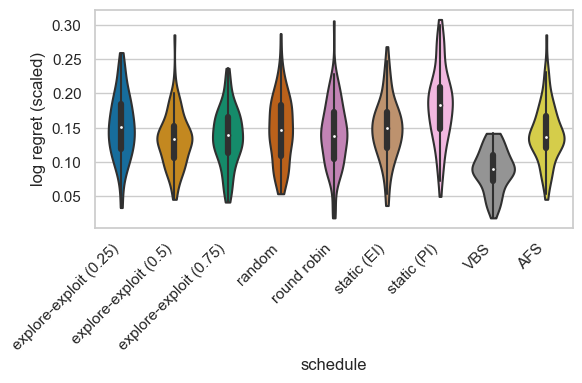

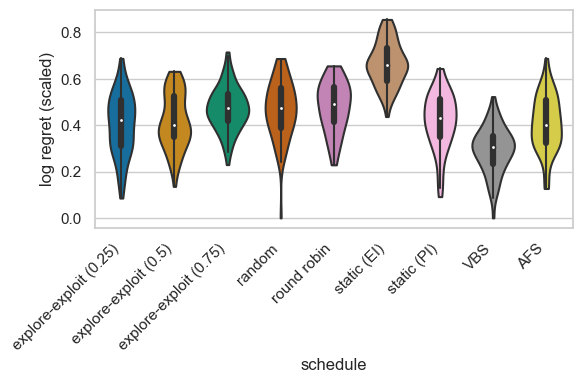

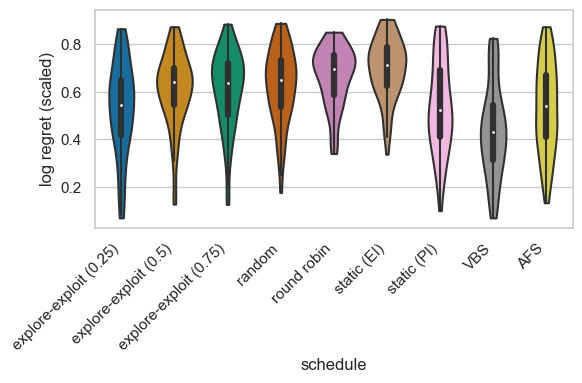

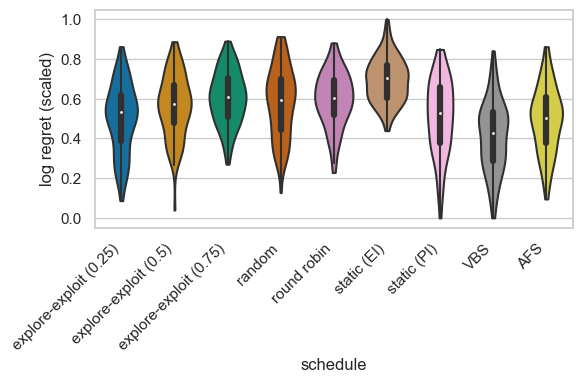

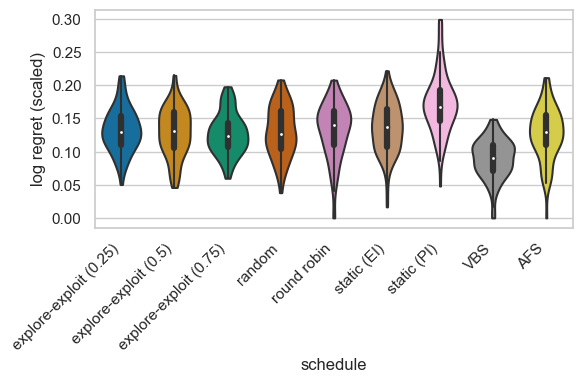

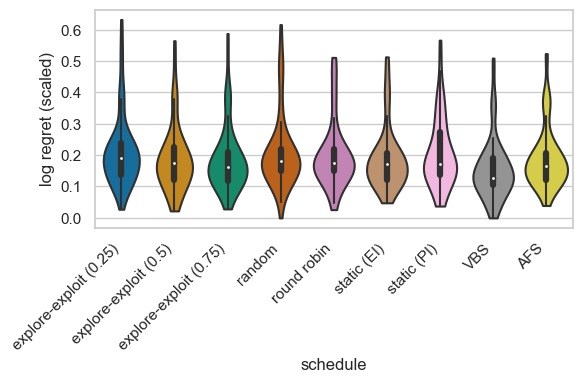

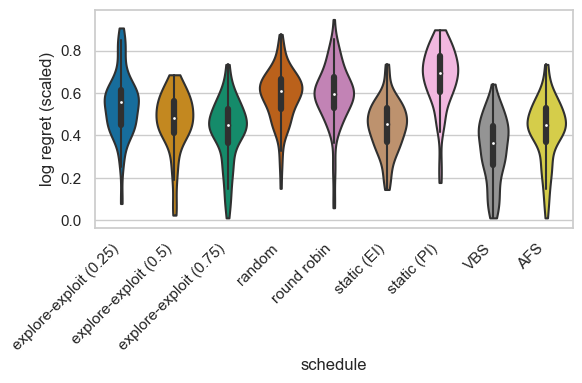

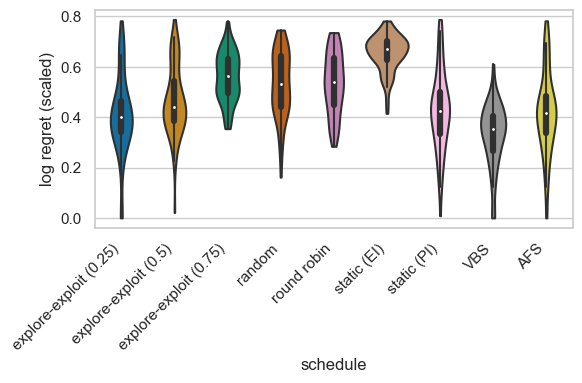

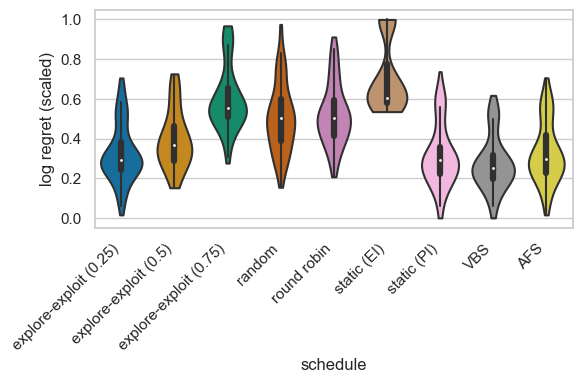

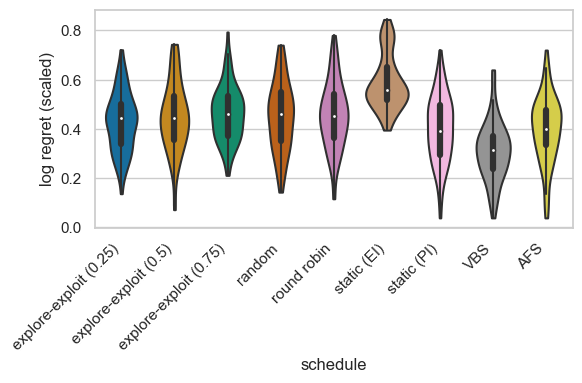

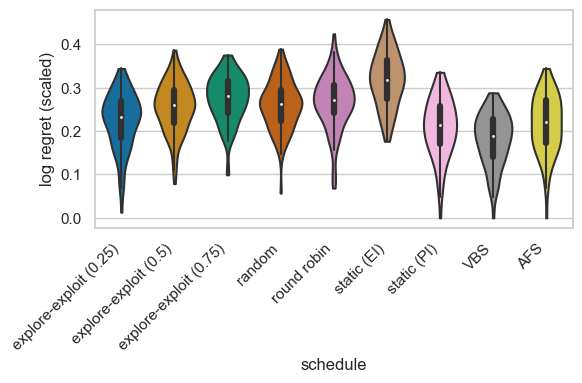

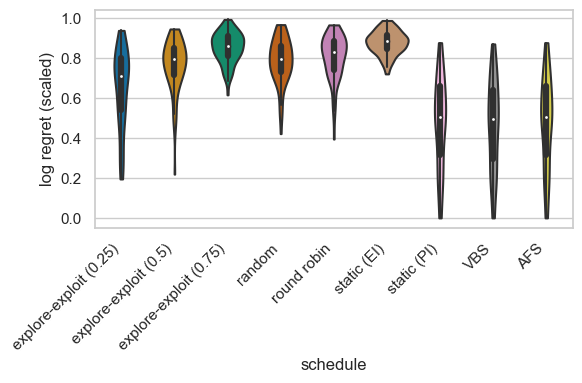

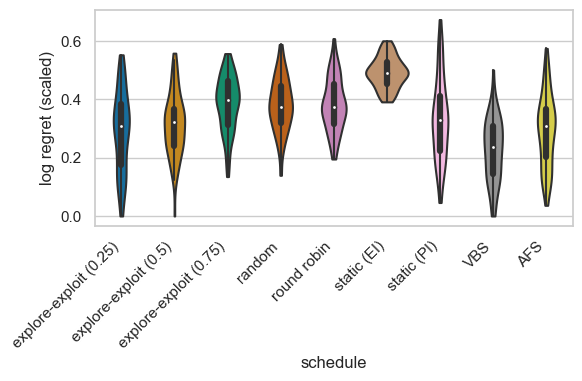

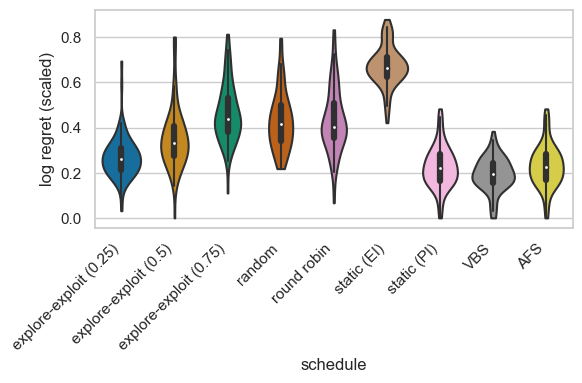

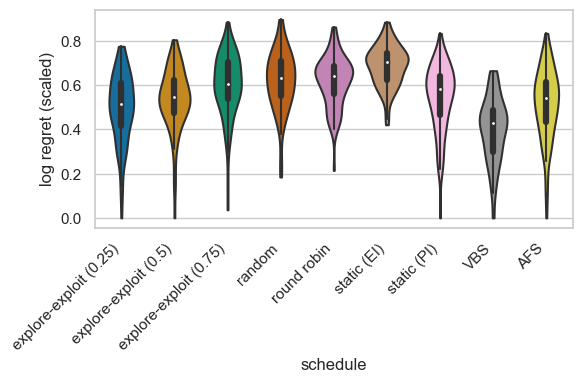

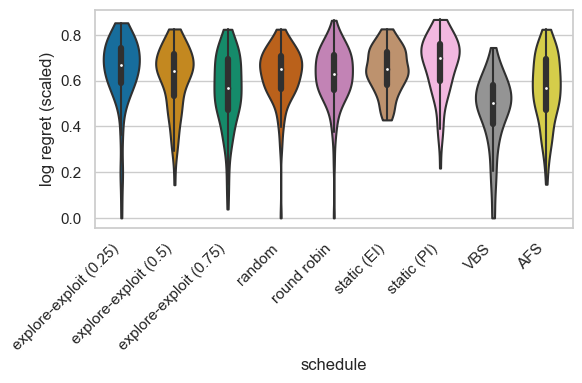

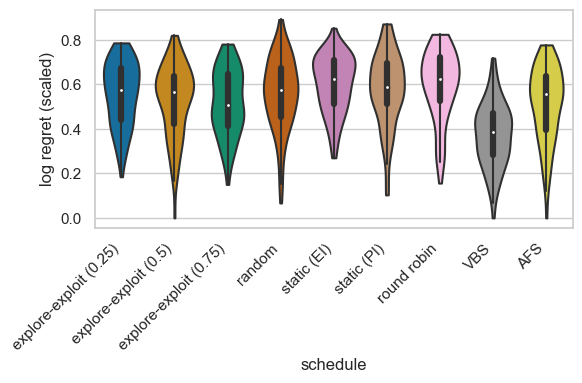

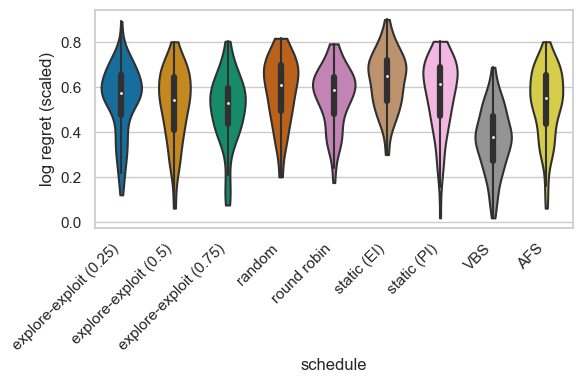

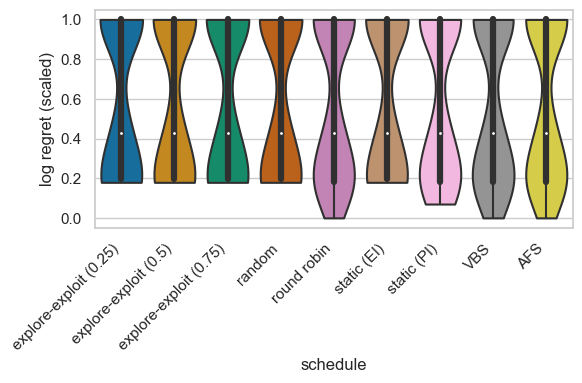

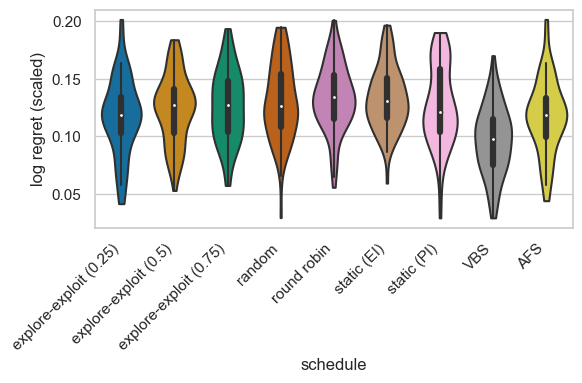

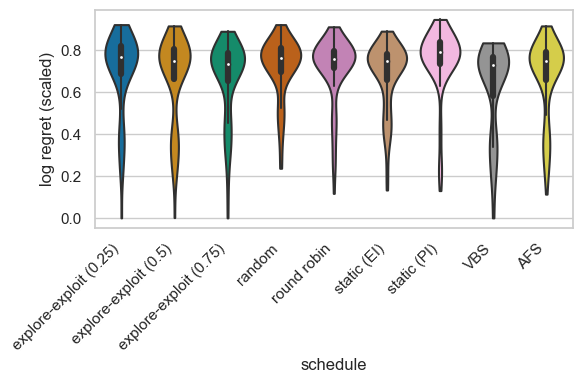

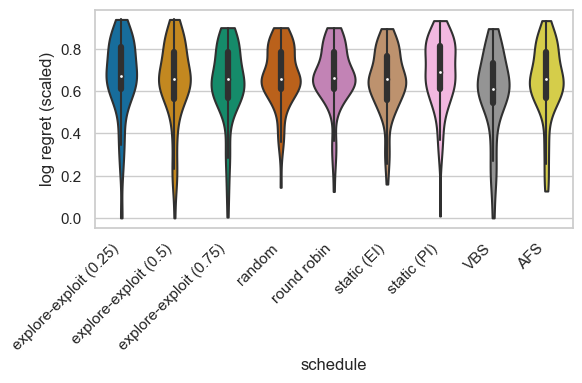

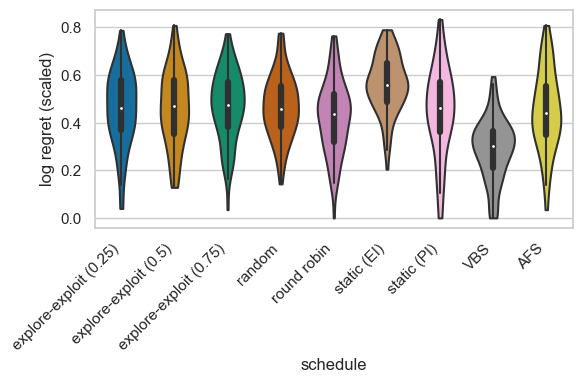

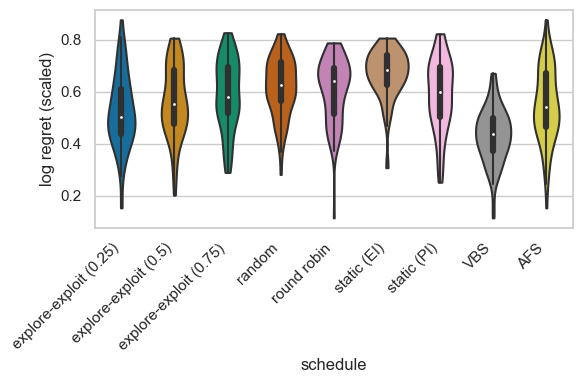

In [34]:
from plot_utils import *
import seaborn as sns
import pandas as pd


df = rollout_data
df = df[df["step"] == performance_at_step]
df = filter_by_testset(df, index_df)
if not is_eipiafs:
    df = pd.concat((df, vbs_df, sel_df))
    figsize = (6, 4)
    sns.set(font_scale=1)
else:
    df = pd.concat((df, sel_df))
    figsize = (4, 3)
    sns.set(font_scale=1.25)

sns.set_style("whitegrid")
sns.set_palette("colorblind")

df.columns
group_keys = ["bbob_dimension", "bbob_function"]
groups = df.groupby(by=group_keys)
for group_id, group_df in groups:
    if type(group_id) != tuple:
        group_id = [group_id]
    if group_id[0] != 5:
        continue
    title = get_group_title(group_keys=group_keys, group_id=group_id)

    data = group_df
    yname = "regret_log_scaled"
    outdir = figoutdir

    # data = scale(data)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax = sns.violinplot(
        data=data,
        x="policy_name",
        y=yname,
        ax=ax,
        palette=get_color_palette(data),
        cut=0,
    )
    # ax = sns.stripplot(x="policy_name", y=yname, data=data, size=2, color="black", linewidth=0, ax=ax)
    if not "log" in yname:
        ax.set_yscale("log")
    # else:
    #     ax.set_ylim(0, 1)
    title = title.replace("bbob_", "")
    if is_eipiafs:
        title += "_EIPIAFS"
    # ax.set_title(title)
    ax.set_xlabel("schedule")
    ax.set_ylabel("log regret (scaled)")
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")
    fig.set_tight_layout(True)
    savefig(fig=fig, basename=f"{outdir}/boxplot/incumbentregret_{title}", extension=".pdf")
    plt.show()

## Convergence
Regret over time.
Without VBS, AFS.

In [ ]:
from plot_utils import *
import seaborn as sns
import pandas as pd

sns.set(font_scale=1.15)


df = rollout_data
df = df[df["step"] == performance_at_step]
df = filter_by_testset(df, index_df)
df = pd.concat((df, vbs_df, sel_df))

sns.set_style("whitegrid")
sns.set_palette("colorblind")
figoutdir = "tmp/meta_learning_bbob/ela"
df.columns
group_keys = ["bbob_dimension", "bbob_function"]
groups = df.groupby(by=group_keys)
for group_id, group_df in groups:
    if type(group_id) != tuple:
        group_id = [group_id]
    if group_id[0] != 5:
        continue
    title = get_group_title(group_keys=group_keys, group_id=group_id)

    data = group_df
    yname = "regret_log_scaled"
    outdir = figoutdir

    # data = scale(data)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax = sns.violinplot(
        data=data,
        x="policy_name",
        y=yname,
        ax=ax,
        palette=get_color_palette(data),
        cut=0,
    )
    # ax = sns.stripplot(x="policy_name", y=yname, data=data, size=2, color="black", linewidth=0, ax=ax)
    if not "log" in yname:
        ax.set_yscale("log")
    # else:
    #     ax.set_ylim(0, 1)
    title = title.replace("bbob_", "")
    # ax.set_title(title)
    ax.set_xlabel("schedule")
    ax.set_ylabel("log regret (scaled)")
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")
    fig.set_tight_layout(True)
    savefig(fig=fig, basename=f"{outdir}/boxplot/incumbentregret_{title}", extension=".pdf")
    plt.show()

## Add Full Runs of VBS, AFS to Plot Data

In [7]:
# Add full runs of VBS, AFS to rollout data

from plot_utils import *
import seaborn as sns
import pandas as pd
from tqdm import tqdm

df = rollout_data
df = df[df["step"] <= performance_at_step]
df = filter_by_testset(df, index_df)

# groupkeys = ["bbob_dimension", "bbob_function", "bbob_instance", "seed"]
# groups = df.groupby(by=groupkeys)
def add_selector(df, selected_schedules, name="AFS"):
    afs_df = []
    for i, (idx, index) in tqdm(enumerate(index_df.iterrows()), total=len(index_df)):
        schedule = selected_schedules[i]
        fid = index["bbob_function"]
        dim = index["bbob_dimension"]
        inst = index["bbob_instance"]
        seed = index["seed"]
        subdf = df[
            (df["bbob_function"] == fid)
            & (df["bbob_dimension"] == dim)
            & (df["bbob_instance"] == inst)
            & (df["seed"] == seed)
            & (df["policy_name"] == schedule)
        ]
        sub_df = subdf.copy()
        subdf["policy_name"] = name
        afs_df.append(subdf)
    afs_df = pd.concat(afs_df)
    return afs_df


selected_schedules_afs = [schedules[i] for i in id_schedules_pred]
ids_sc_vbs = np.argmin(y_test, axis=1)
selected_schedules_vbs = [schedules[i] for i in ids_sc_vbs]

afs_df = add_selector(df=df, selected_schedules=selected_schedules_afs, name="AFS")
vbs_c_df = add_selector(df=df, selected_schedules=selected_schedules_vbs, name="VBS")

df = pd.concat((df, vbs_c_df, afs_df))
df.to_csv(fn_convergence_df_afsvbs, index=False)

  0%|          | 0/2160 [00:00<?, ?it/s]/tmp/ipykernel_30035/4124413324.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf["policy_name"] = name
  0%|          | 0/2160 [00:00<?, ?it/s]/tmp/ipykernel_30035/4124413324.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf["policy_name"] = name
100%|██████████| 2160/2160 [02:00<00:00, 17.94it/s]


## Convergence with VBS + AFS

/tmp/ipykernel_1629/3995931114.py:40: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group_id, group_df in groups:


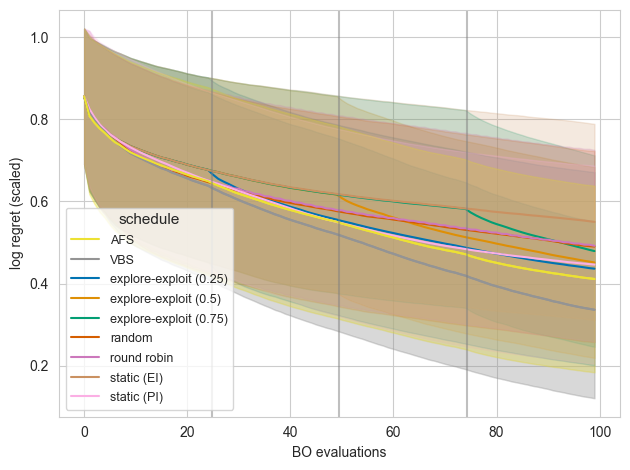

In [12]:
# Plot convergence
import importlib
import plot_utils

importlib.reload(plot_utils)
from plot_utils import *

sns.set_style("whitegrid")
sns.set_palette("colorblind")
figoutdir = "tmp/meta_learning_bbob/ela"
df = pd.read_csv(fn_convergence_df_afsvbs).reset_index(drop=True)
schedules = list(df["policy_name"].unique())
schedules.sort()
df.columns
group_keys = ["bbob_dimension"] #, "bbob_function"]
df = pd.read_csv(fn_convergence_df_afsvbs)
mapper = {
    "explore-exploit (0.25)": "explore-exploit (25%)",
    "explore-exploit (0.5)": "explore-exploit (50%)",
    "explore-exploit (0.75)": "explore-exploit (75%)",
}
# for key, value in mapper.items():
#     df[df["policy_name"] == key] = value
names = [
    "explore-exploit (25%)",
    "explore-exploit (50%)",
    "explore-exploit (75%)",
    "static (PI)",
    "static (EI)",
    "random",
    "round robin",
    "AFS",
    "VBS"
]
# df = df[(df["policy_name"] != "VBS") & (df["policy_name"] != "AFS")]
palette = sns.color_palette(palette="colorblind", n_colors=len(names))
palette = {n: p for n, p in zip(names, palette)}
palette = None
groups = df.groupby(by=group_keys)
for group_id, group_df in groups:
    if type(group_id) != tuple:
        group_id = [group_id]
    if group_id[0] != 5:
        continue
    title = get_group_title(group_keys=group_keys, group_id=group_id)

    hue_order = schedules + ["VBS", "AFS"]

    plot_regret_over_steps(
        data=group_df, title=title, yname="regret_log_scaled", errorbar="sd", outdir=figoutdir, hue_order=hue_order, extension=".png", palette=palette
    )

In [16]:
palette

{'explore-exploit (25%)': (0.00392156862745098,
  0.45098039215686275,
  0.6980392156862745),
 'explore-exploit (50%)': (0.8705882352941177,
  0.5607843137254902,
  0.0196078431372549),
 'explore-exploit (75%)': (0.00784313725490196,
  0.6196078431372549,
  0.45098039215686275),
 'static (PI)': (0.8352941176470589, 0.3686274509803922, 0.0),
 'static (EI)': (0.8, 0.47058823529411764, 0.7372549019607844),
 'random': (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 'round robin': (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 'AFS': (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 'VBS': (0.9254901960784314, 0.8823529411764706, 0.2)}

## Ranks
### Compute Ranks

In [43]:
from plot_utils import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import rankdata

figoutdir = "tmp/meta_learning_bbob/ela/figures"
outdir = figoutdir

if is_eipiafs:
    schedules = [s for s in schedules if s in ["static (PI)", "static (EI)"]]

df = index_df.copy()
_schedules = schedules + ["AFS"]
perf_afs = sel_df["regret_log_scaled"].to_numpy()
perf_vbs = vbs_df["regret_log_scaled"].to_numpy()
_y_test = np.concatenate((y_test, perf_afs[:, None]), axis=1)
ranks = []
for y in _y_test:
    A = y
    ids = np.arange(0, len(A))
    sort_ids = np.argsort(A)
    ids_sorted = ids[sort_ids]
    rank = rankdata(y, method="dense")
    ranks.append(rank)
ranks = np.array(ranks)

for i, schedule in enumerate(_schedules):
    df[schedule] = ranks[:, i]
df = pd.melt(df, id_vars=[c for c in df.columns if c not in _schedules], var_name="policy_name", value_name="rank")
rank_df = df
rank_df.to_csv(fn_rank_df, index=False)

### Plot Ranks

In [47]:
# Subtract one because AFS always has the same rank as one of the others
sns.set(font_scale=1.25)
sns.set_style("whitegrid")
n_bins = df["policy_name"].nunique() - 1
# n_bins = len(schedules)
# n_bins = 20
min_val = df["rank"].min()
max_val = df["rank"].max() + 1
val_width = max_val - min_val
bin_width = val_width / n_bins
xticks = np.arange(min_val - bin_width / 2, max_val + bin_width / 2, bin_width)[1:]
if is_eipiafs:
    xticks = [xticks[0], 2.5]
xticklabels = [f"{x+bin_width/2:0f}" for x in xticks]
xticklabels = np.arange(1, len(xticklabels) + 1)

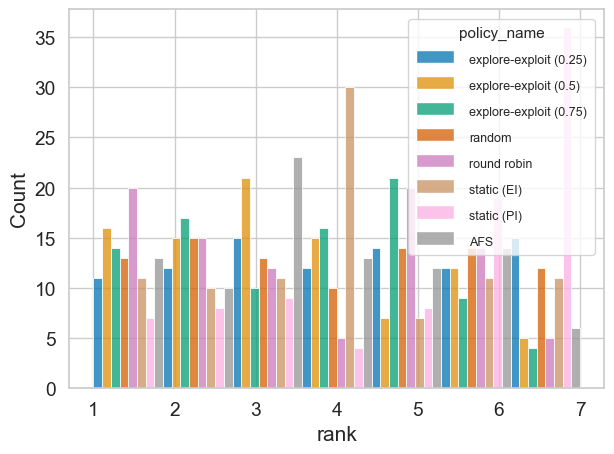

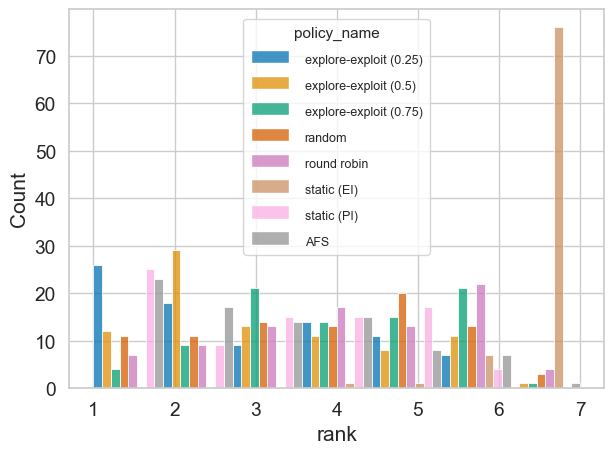

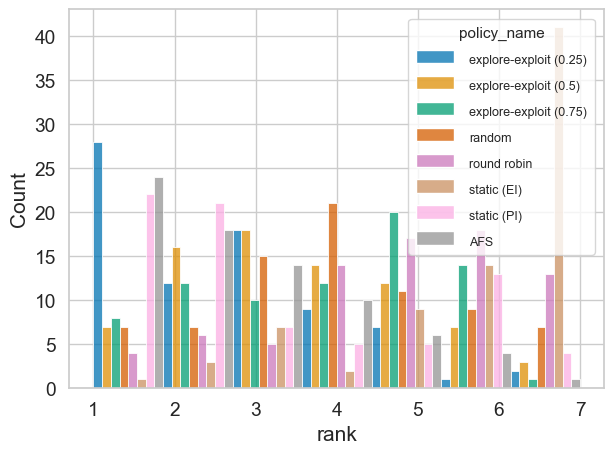

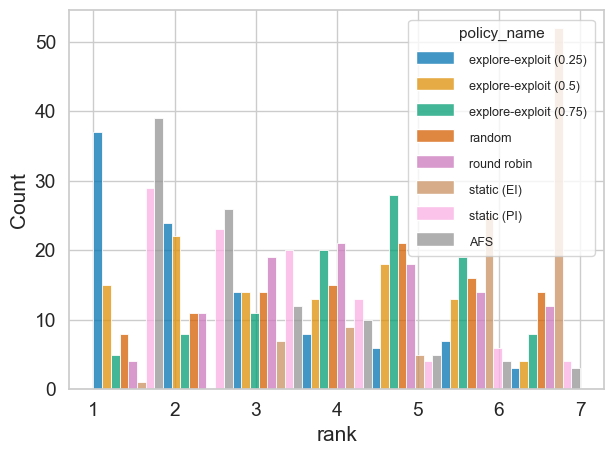

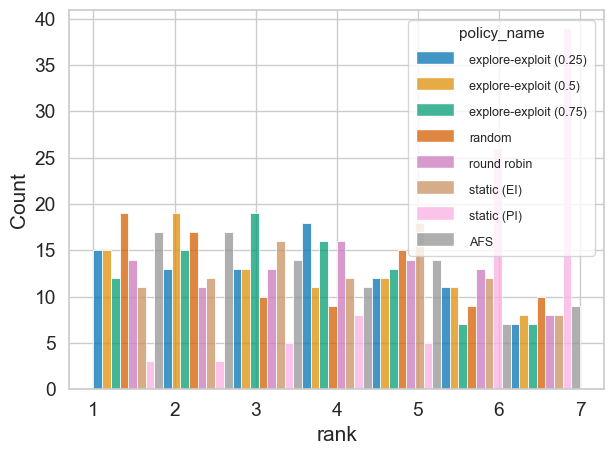

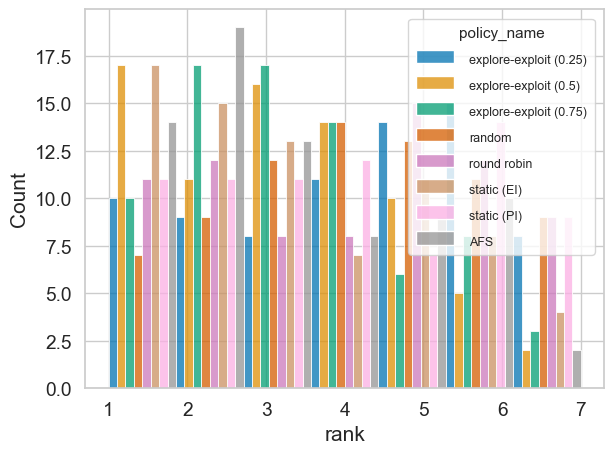

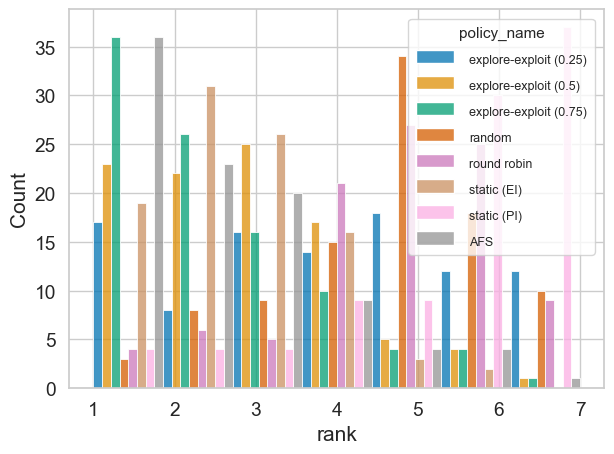

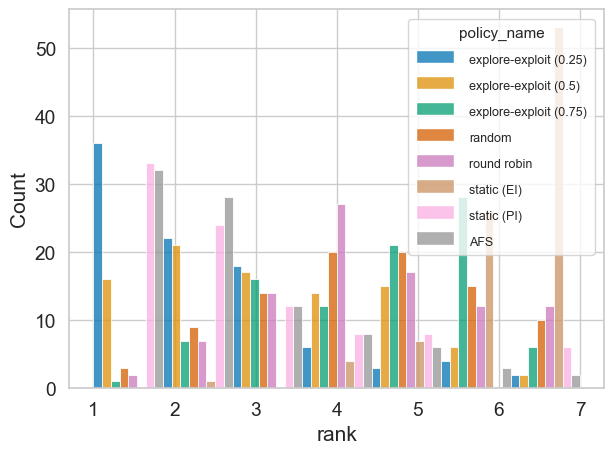

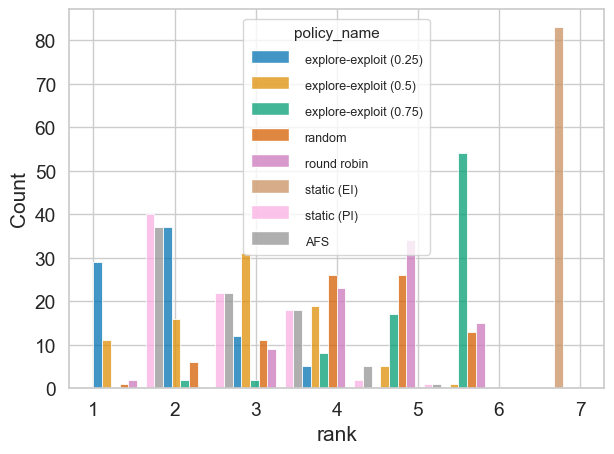

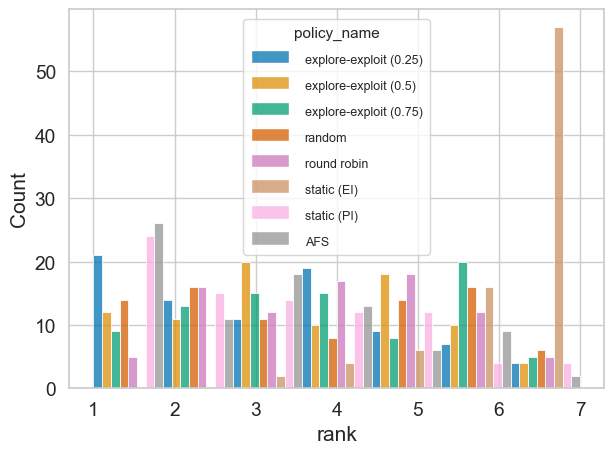

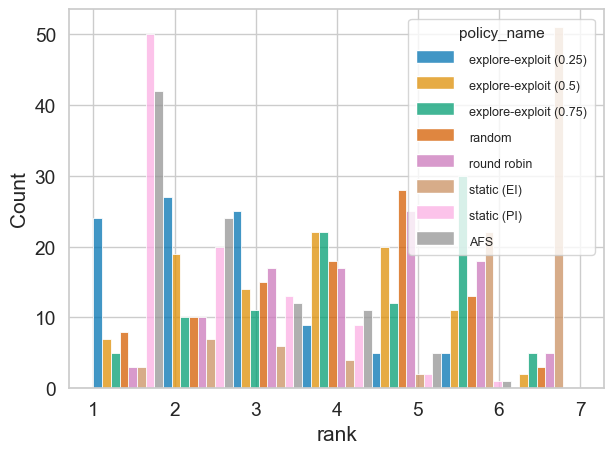

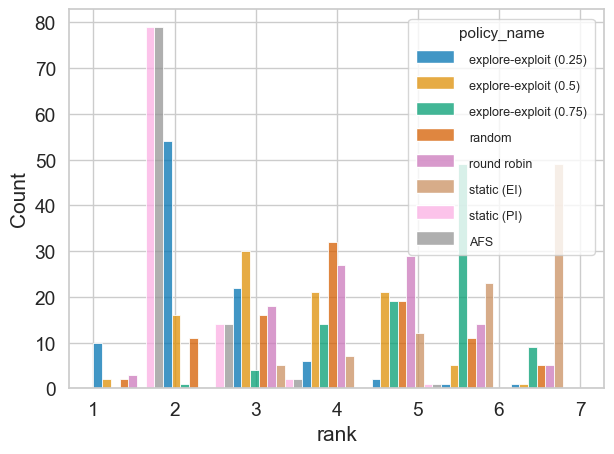

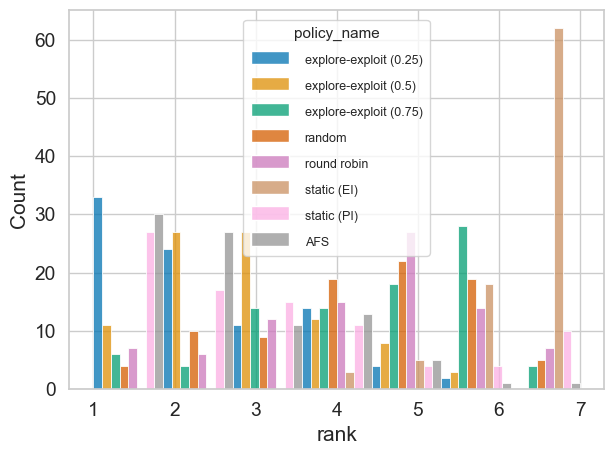

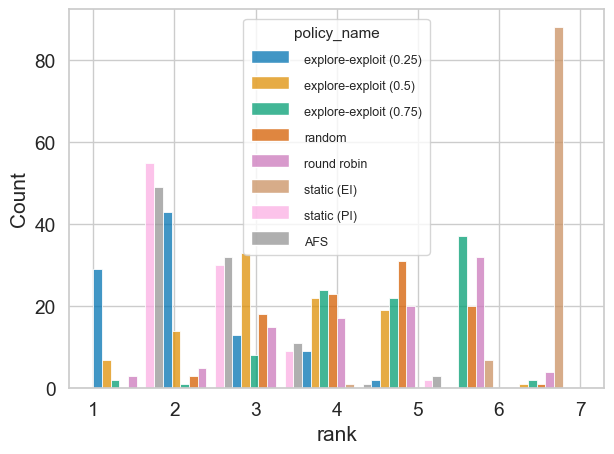

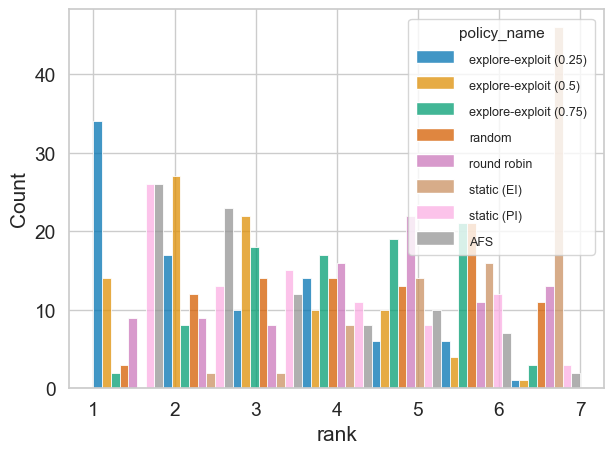

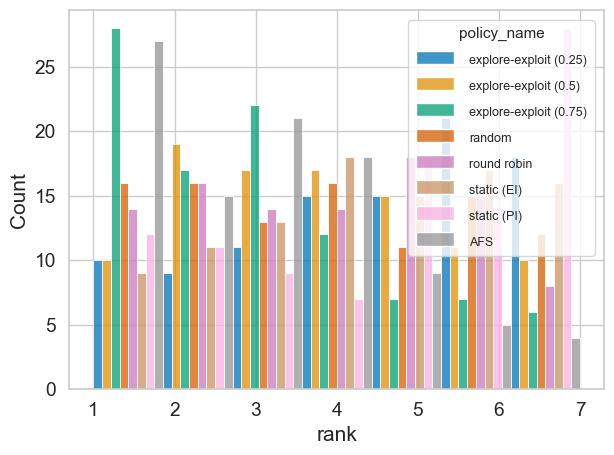

KeyboardInterrupt: 

In [67]:
sns.set(font_scale=1.25)
sns.set_style("whitegrid")
group_keys = ["bbob_dimension", "bbob_function"]
groups = df.groupby(by=group_keys)
for group_id, group_df in groups:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax = sns.histplot(
        data=group_df,
        x="rank",
        hue="policy_name",
        ax=ax,
        bins=n_bins,
        multiple="dodge",
        hue_order=[h for h in hue_order if h != "VBS"],
        palette="colorblind",
    )
    # ax.set_title(group_id)
    _xticks = ax.get_xticks()[1:-1]
    ax.set_xticks(_xticks)
    # ax.set_xticklabels(_xticklabels)
    # ax.legend(title="schedule")
    plt.setp(ax.get_legend().get_texts(), fontsize="9")
    plt.setp(ax.get_legend().get_title(), fontsize="11")
    fig.set_tight_layout(True)
    title = group_id
    if is_eipiafs:
        title += "_EIPIAFS"
    savefig(fig=fig, basename=f"{outdir}/histogram/rank_{title}", extension=".png")
    plt.show()
    break

In [48]:
xticks, xticklabels

(array([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]), array([1, 2, 3, 4, 5, 6, 7]))

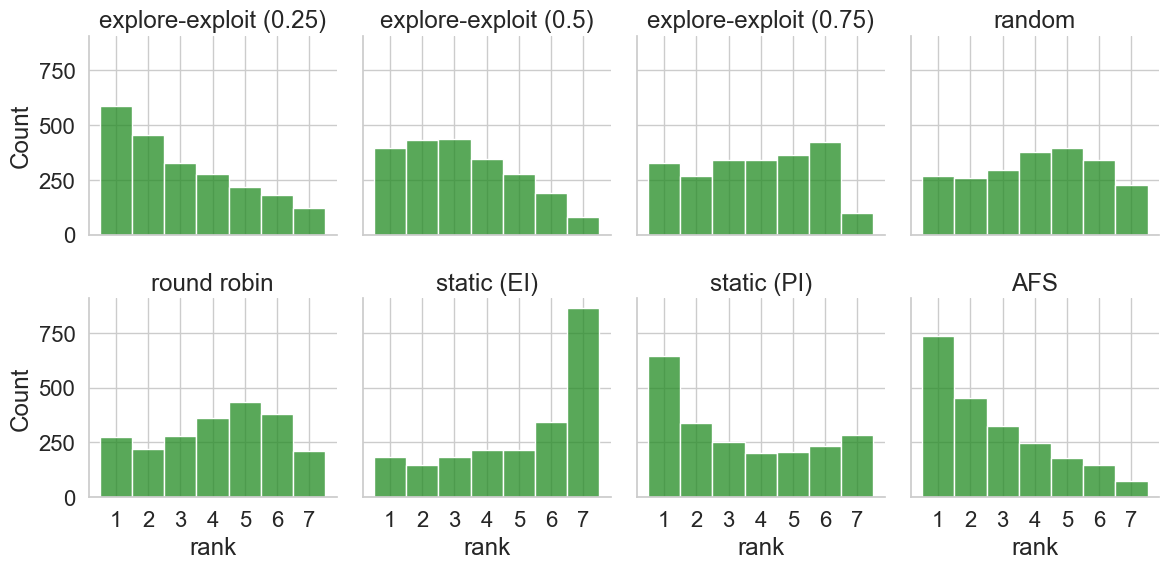

In [71]:
if is_eipiafs:
    identifier = "_EIPIAFS"
else:
    identifier = ""
    sns.set(font_scale=1.45)
    sns.set_style("whitegrid")

g = sns.FacetGrid(data=df, col="policy_name", col_wrap=4)
g.map_dataframe(sns.histplot, x="rank", bins=n_bins, binrange=(min_val, max_val), color="forestgreen")
g.set_titles(col_template="{col_name}")
g.set(xticks=xticks)
g.set_xticklabels(xticklabels)
fig = g.figure
fig.set_tight_layout(True)
savefig(fig=fig, basename=f"{outdir}/histogram/aggregated{identifier}", extension=".pdf")
plt.show()

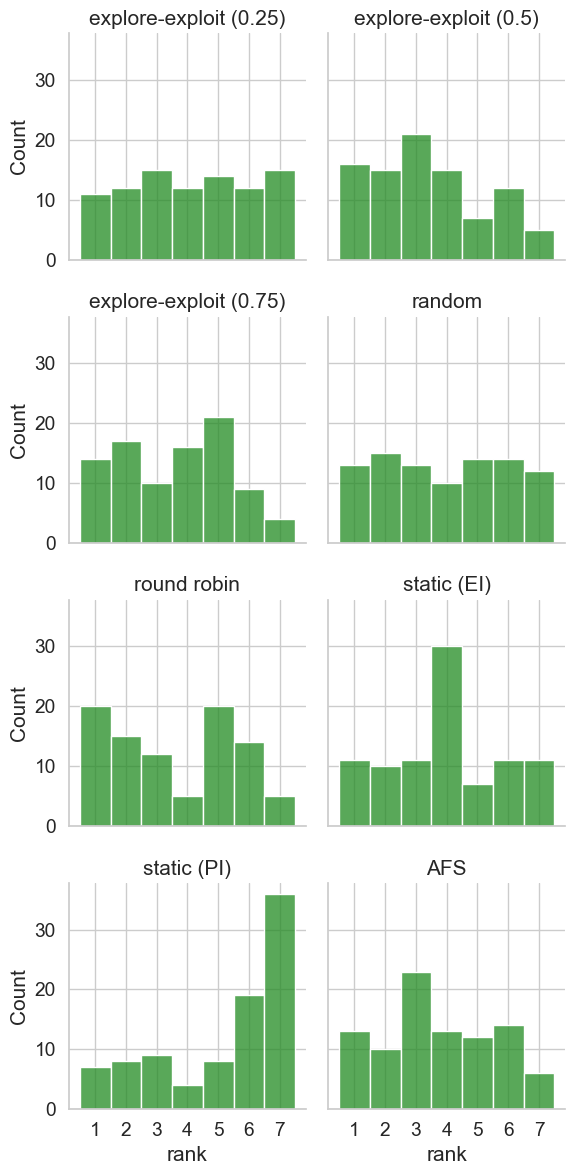

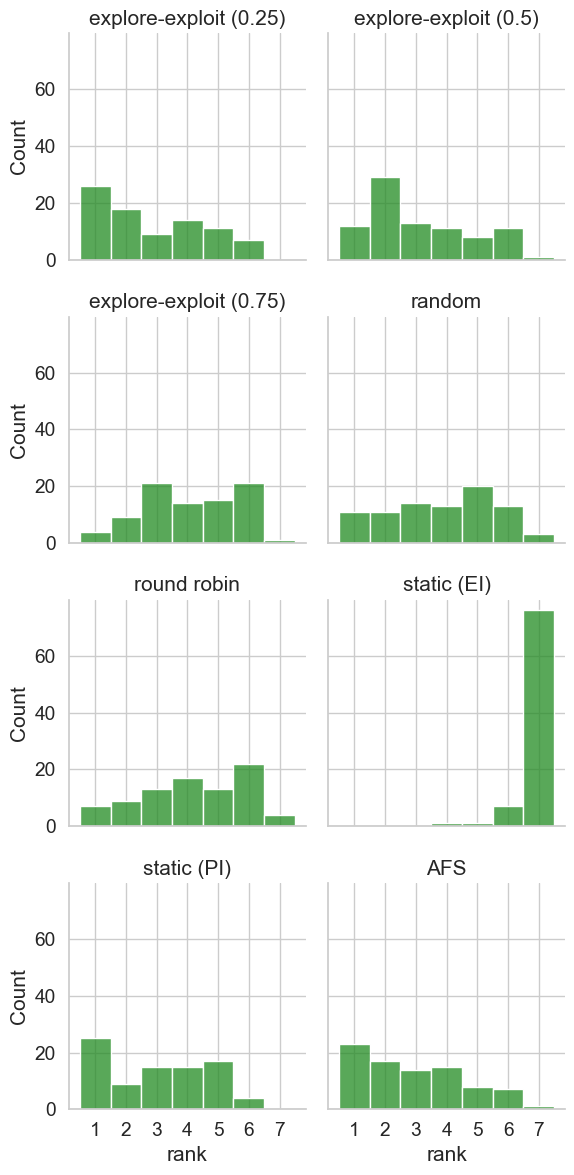

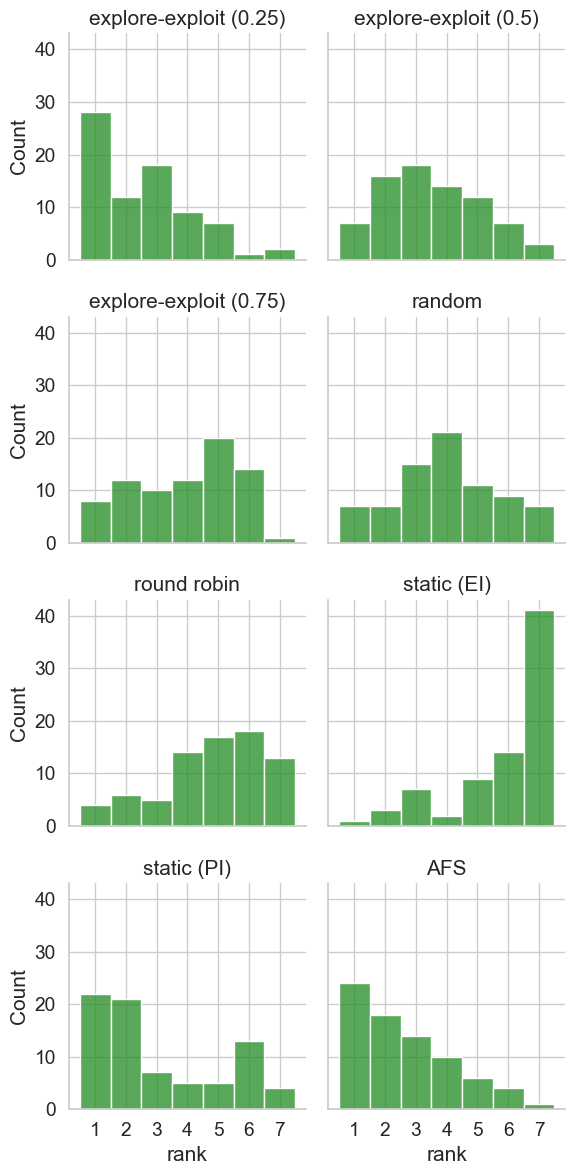

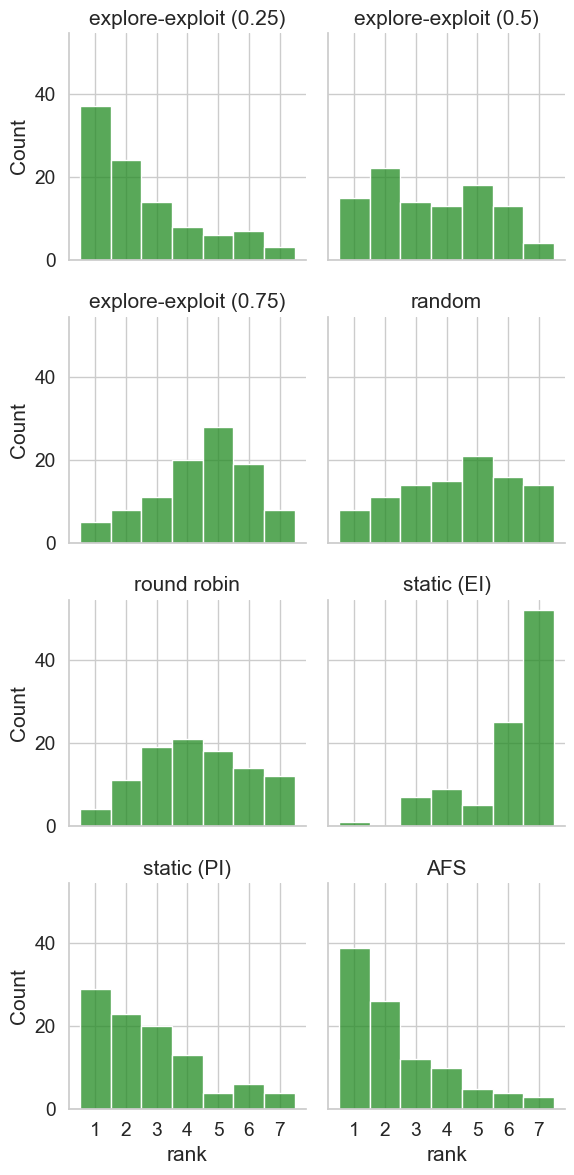

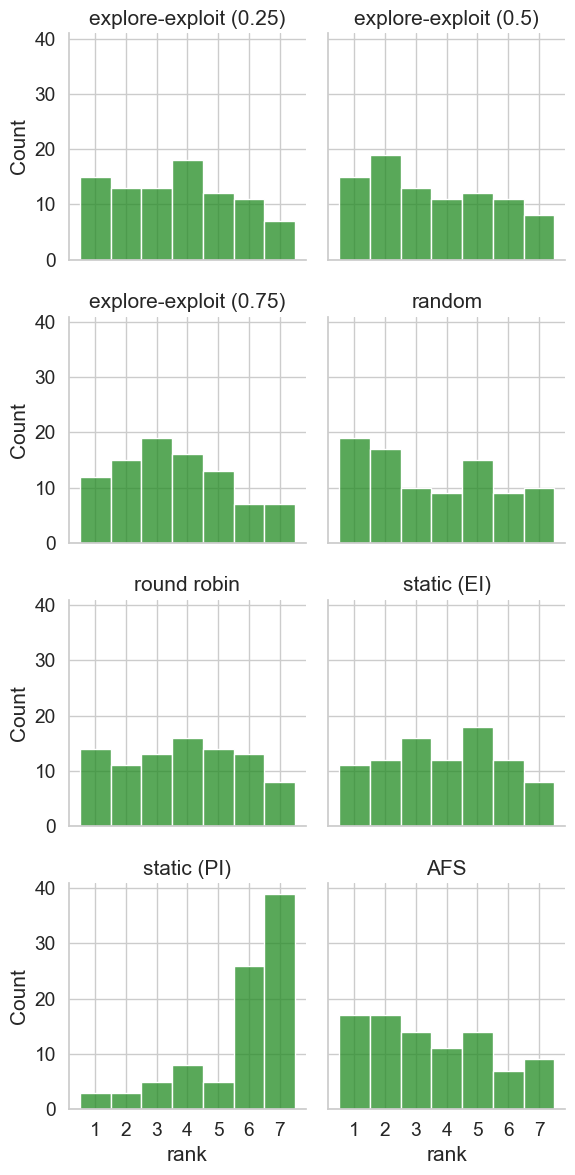

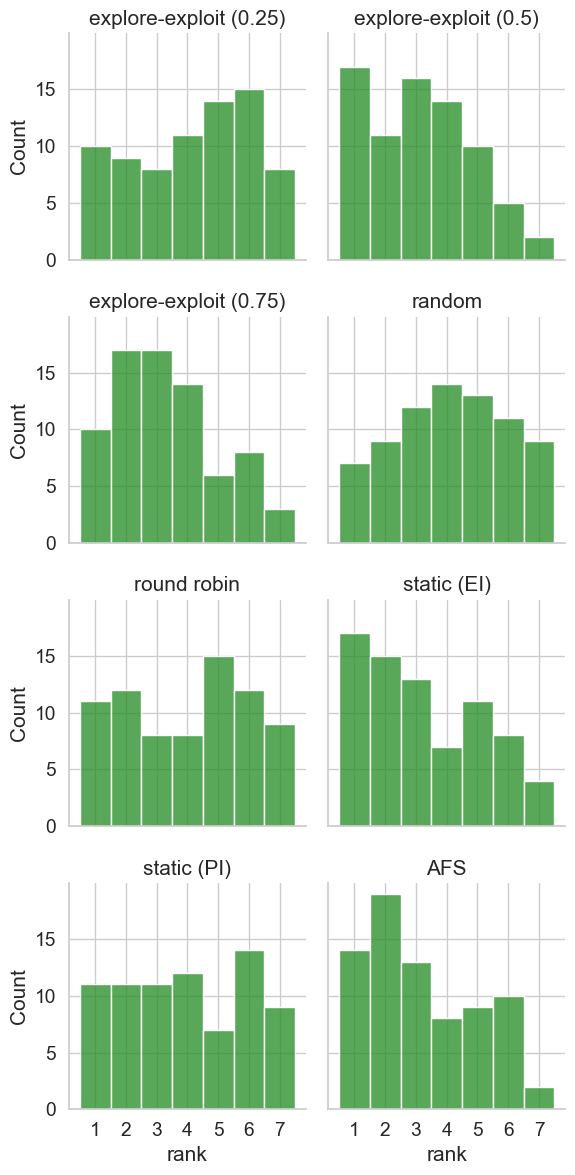

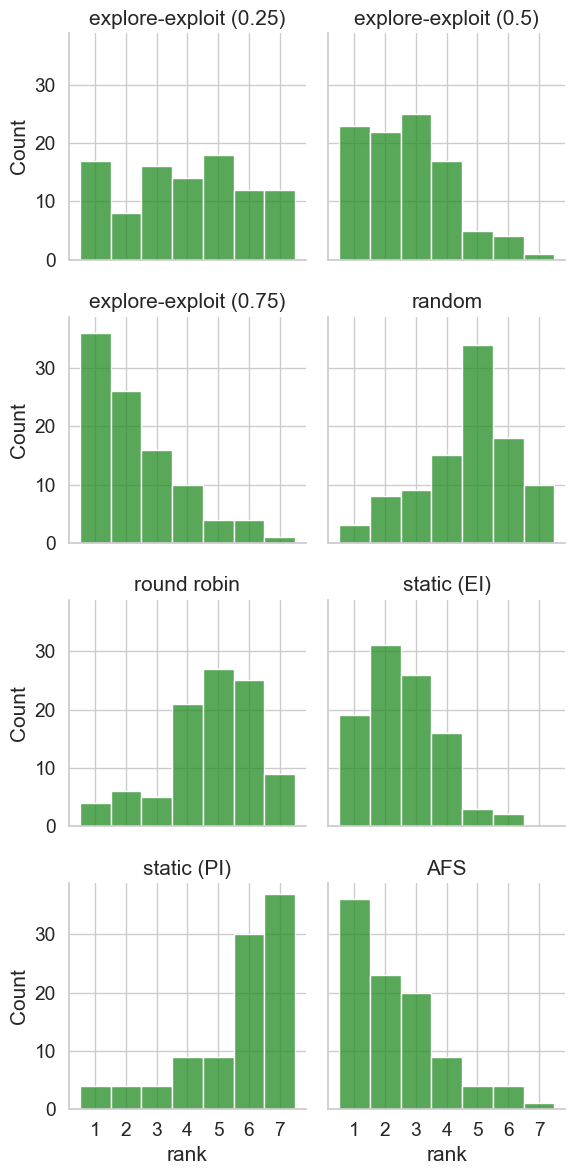

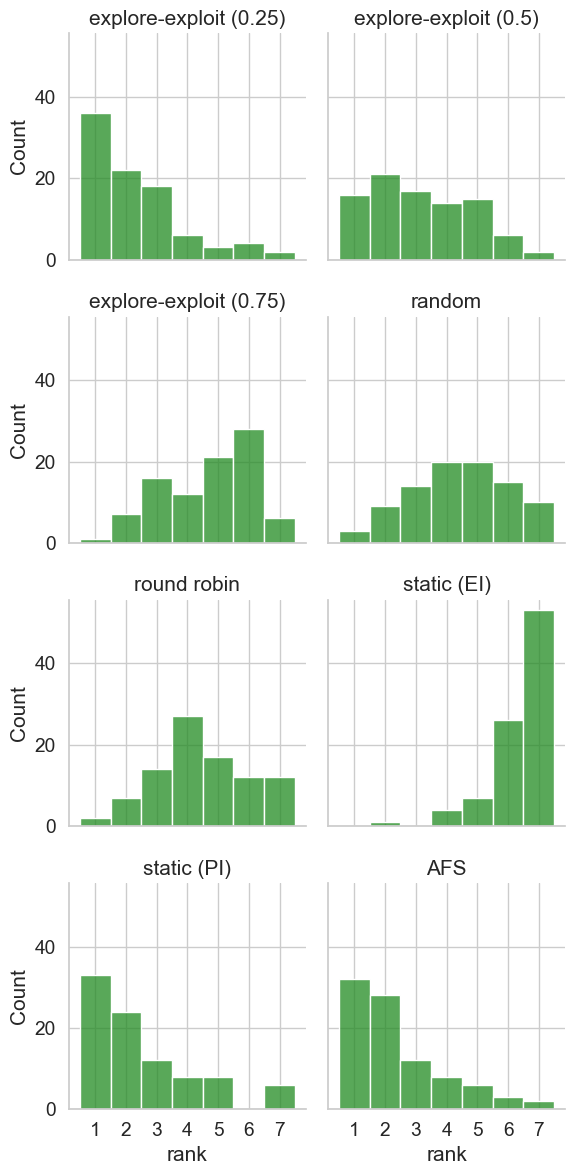

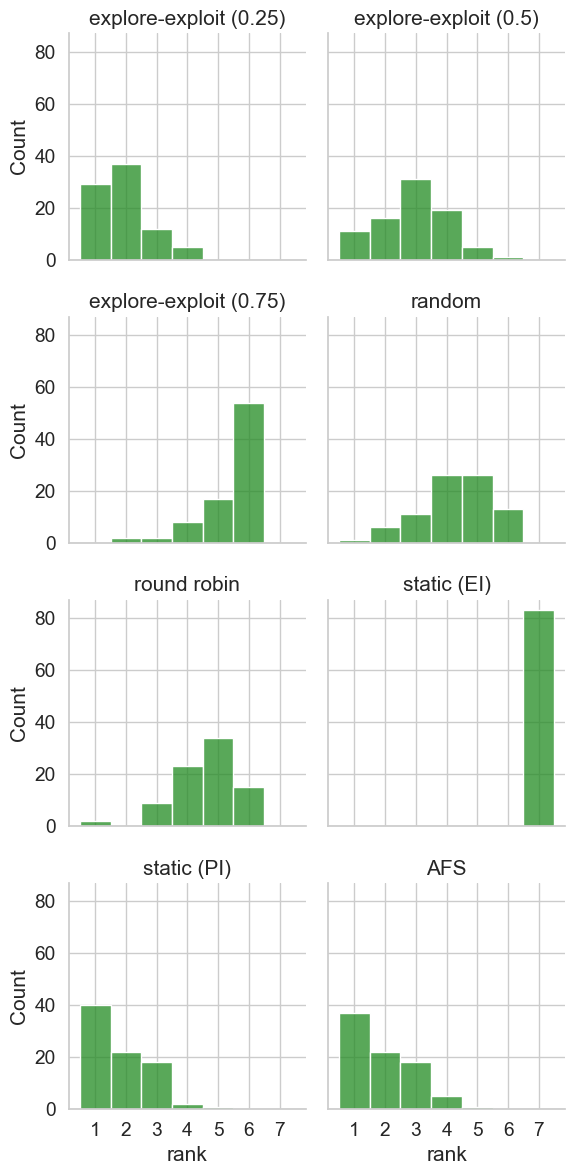

KeyboardInterrupt: 

In [69]:
# Per BBOB Function
group_keys = ["bbob_dimension", "bbob_function"]
df = pd.read_csv(fn_rank_df)
groups = df.groupby(by=group_keys)
for group_id, group_df in groups:
    if type(group_id) != tuple:
        group_id = [group_id]
    if group_id[0] != 5:
        continue
    title = get_group_title(group_keys=group_keys, group_id=group_id)
    title = title.replace("bbob_", "")
    if is_eipiafs:
        title += "_EIPIAFS"

    g = sns.FacetGrid(data=group_df, col="policy_name", col_wrap=2)  # , row="bbob_function")
    g.map_dataframe(sns.histplot, x="rank", bins=n_bins, binrange=(min_val, max_val), color="forestgreen")
    g.set_titles(template="{col_name}")
    g.set(xticks=xticks)
    g.set_xticklabels(xticklabels)
    fig = g.figure
    fig.set_tight_layout(True)
    savefig(fig=fig, basename=f"{outdir}/histogram/perbbob_{title}", extension=".pdf")
    plt.show()

In [ ]:
g = sns.FacetGrid(data=df, col="bbob_function", col_wrap=6, legend_out=True)
g.map_dataframe(
    sns.histplot,
    x="rank",
    bins=n_bins,
    binrange=(min_val, max_val),
    hue="policy_name",
    multiple="dodge",
    palette="colorblind",
)
g.set_titles(col_template="{col_name}")
g.set(xticks=xticks)
g.set_xticklabels(xticklabels)
fig = g.figure
fig.set_tight_layout(True)
savefig(fig=fig, basename=f"{outdir}/histogram/perbbob_hueschedule", extension=".pdf")
plt.show()

In [46]:
rank_df["rank"].unique()  #
bin_width

0.8571428571428571

In [12]:
df = rollout_data
df = filter_by_testset(df, index_df)
df.to_csv("tmp/meta_learning_bbob/rollout_testset.csv", index=False)

In [15]:
len(rollout_data) / len(df)

3.333399431555291

In [4]:
# Export IOH Table
df = rollout_data
performance_at_step = 99
dimension = 5
table_fn = "tmp/meta_learning_bbob/ioh.csv"
translator = {
    "bbob_function": "function",
    "policy_name": "schedule",
    "bbob_instance": "instance",
    "seed": "seed",
    "regret": "final regret",
    "regret_log_scaled": "final scaled log regret",
}
data = df[df["bbob_dimension"] == dimension]
data = data[data["step"] == performance_at_step]
# data = scale(data)
print(data.columns)
table = {v: data[k] for k, v in translator.items()}
table = pd.DataFrame(table)
table.reset_index(drop=True, inplace=True)
table.to_csv(table_fn, index=False)
print(table["final scaled log regret"].min(), table["final scaled log regret"].max())
print(len(table))

Index(['step', 'state', 'action', 'reward', 'instance', 'cost',
       'configuration', 'episode', 'policy_name', 'policy', 'seed',
       'bbob_function', 'bbob_instance', 'bbob_dimension', 'regret',
       'regret_log_scaled'],
      dtype='object')
0.0 1.0
50400
